# Search: Solving a Maze Using a Goal-based Agent

Student Name: Jonathan Mejia

I have used the following AI tools: ChatGPT, Google Gemini

I understand that my submission needs to be my own work: JM

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file.


## Introduction

The agent must use a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent
that ignores all percepts and just follows the plan. We do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.**
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state.
* **Discrete** means that we have a **finite set of states.** The maze has a finite set
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [1]:
with open("/content/drive/My Drive/Colab Notebooks/small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](../HOWTOs/working_on_assignments.md).

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [3]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

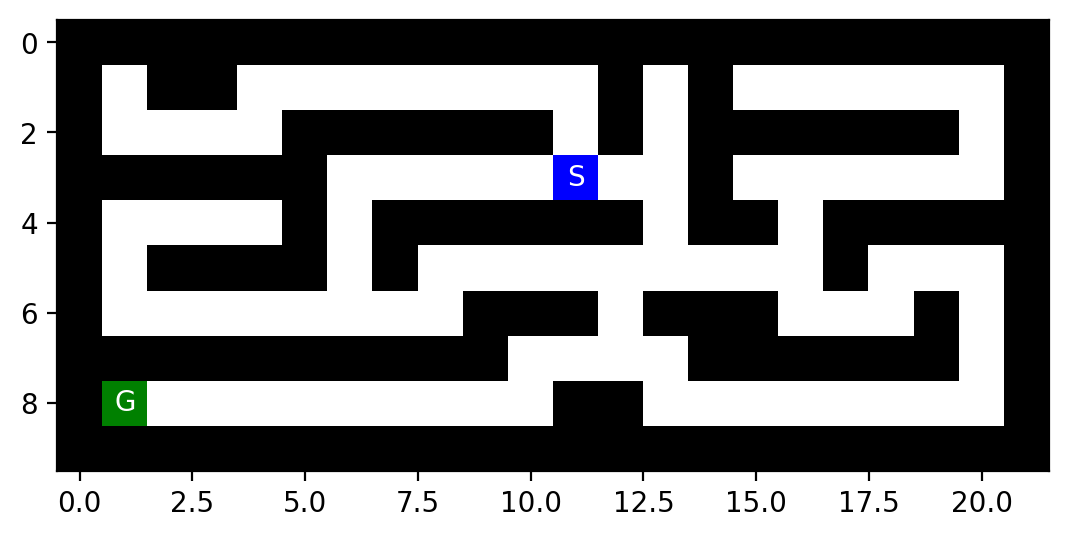

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [5]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [6]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        Build an animation from a list of mazes. Assumes that results has the elements:
        path, reached, actions and maze_anim with a list of maze arrays.
    
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    maze_to_matrix(maze)
        convert a maze a numeric numpy array for visualization via imshow.
    
 

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [7]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.exp = 0
        self.depth = 0
        self.mem = 0
        self.front = 0
    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

* Initial State: Will begin at the starting position S
* Actions: {N, E, S, W}
* Transition Model: Move a direction
* Goal State: Reaching Position G
* Path Cost: Sum of number of actions

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

* $n$: state space size - would be dependent on the size of the maze and its available spaces
* $d$: depth of the optimal solution - Would be dependent on the type of search being done and the shortest path achieved
* $m$: maximum depth of tree - is determined based on the search method being used for the worst performance and largest space utilized
* $b$: maximum branching factor - is determined based on the number of actions taken and actions of those actions.

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking.
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

In [8]:
# The following code is implemented based on the class lecture
# bfs represents breadth first search algorithm
def bfs(maze_name):
  #print("Start location:", mh.find_pos(maze_name, what = "S"))
  # The following will gather the starting position of the maze
  root = Node(mh.find_pos(maze_name, what = "S"),parent=None, action =None, cost = 0)
  # Return the node if the node gathered is at the Goal
  if root.pos == mh.find_pos(maze_name, what = "G"):
    return root
  frontier = [root]
  reached = {root.pos}
  cost = 0
  #The following is used to keep track of the expanding nodes
  expan = 0
  #The following is used to keep track of the depth
  dep = 0
  frontier_size = 0
  while not frontier == []:
    num = 0
    node = frontier.pop(0)
    expan += 1
    #Checks for each valid direction
    for child in expand(maze_name, node):
      s = child.pos
      child.depth = node.depth + 1
      dep = max(dep,child.depth)
      #Checks if the goal reached and returns the node
      if mh.find_pos(maze_name, what = "G") == s:
        child.exp = expan
        child.depth = dep
        child.mem = len(reached)
        child.front = frontier_size
        return child
        #If the nodes position is not in the reached data structure
        # add to the reached data structure and add the node to the frontier
      if s not in reached:
        reached.add(s)
        frontier.append(child)
      frontier_size = max(frontier_size,len(frontier))
  return None

#This will help to return cost if the position is not the same
#as the previous position
def action_cost(position,action,s_):
  if s_ == position:
    return 0.0
  else:
    return 1.0

#Returns the valid action to take and returns the next position
def result(node,action):
  position = node.pos
  if action == "North": position = position[0] - 1, position[1]
  if action == "South": position = position[0] + 1, position[1]
  if action == "East": position = position[0], position[1] + 1
  if action == "West": position = position[0], position[1] - 1
  return position

#Returns if the actions if is valid based on if there is a free space
#ahead or a wall with will then return the direction as false.
def actions(maze_name, pos):
  position = pos
  actions = {"West":[0,-1],"East":[0,1],"North":[-1,0],"South":[1,0]}
  valid_actions = {}
  for dir, (x,y) in actions.items():
    position = pos[0] + x, pos[1] + y
    if maze_name[position] == "X":
      valid_actions[dir] = False
    else:
      valid_actions[dir] = True

  return valid_actions

# The following function is used to return all the next nodes
# to take in the directions that are valid.
def expand(maze_name,node):
  position = node.pos
  try:
    for action, is_valid in actions(maze_name, position).items():
      if is_valid:
        s_ = result(node,action)
        if s_ != position:
          cost = node.cost + action_cost(position,action,s_)
        else: cost = node.cost
        yield Node(s_,node,action,cost)
      continue
  except TypeError:
    print("Not working")

In [9]:
# The following code is implemented based on the class lecture
# bfs represents breadth first search algorithm

def DFS(maze_name):
  #print("Start location:", mh.find_pos(maze_name, what = "S"))
  root = Node(mh.find_pos(maze_name, what = "S"),parent=None, action =None, cost = 0)
  frontier = [(root,[root.pos])]
  expan = 0
  dep = 0
  frontier_size = 0
  #Continue to iterate through frontier until there are no nodes left from the
  #algorithm to take.
  while not frontier == []:
    num = 0
    node, visited = frontier.pop()
    expan += 1
    #print(node," ",path)
    #Return the node when the goal is found.
    if mh.find_pos(maze_name, what = "G") == node.pos:
      node.exp = expan
      node.depth = dep
      node.mem = len(visited)
      node.front = frontier_size
      return node
    #Go through each direction to find the neighboring nodes
    for child in expand(maze_name, node):
      #print(path)
      #print(child.pos)
      child.depth = node.depth + 1
      dep = max(dep,child.depth)
      if child.pos not in visited:
        frontier.append((child,visited + [child.pos]))
    frontier_size = max(frontier_size,len(frontier))
  return None

In [10]:
maze = mh.parse_maze(maze_str)
print(maze_str)
print(bfs(maze))
print(bfs(maze).cost)

maze = mh.parse_maze(maze_str)
print(maze_str)
print(DFS(maze))
print(DFS(maze).cost)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX

Node - pos = (8, 1); action = West; cost = 19.0
19.0
XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX

Node - pos = (8, 1); action = West; cost = 37.0
37.0


How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

* BFS deals with loops by having an array of names reached that gathers all the node positions that have been reached.
* DFS deals with loops by keeping track of visited positions to move to the next action from the path of intersection.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

Yes the implementations are complete and able to find the goal from the starting position. For each algorithm they are optimal in their own way of implementation as DFS searches the furthest path and BFS takes baby steps in each direction but when comparing the two, DFS is not optimal in comparison to BFS.

DFS
Space Complexity: O(b^m)
TIme Complexity: O(b*m)

BFS
Space Complexity: O(b^d)
TIme Complexity: O(b^d)

The difference in space complexity can depend for better usage of algorithms in certain scenarios of luck, given a close goal with many routes BFS can be essential or DFS being found during one hall in a two way path to get to the goal.

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [11]:

import heapq as prior

#The following function is used to implment the Manhattan distance to help the Greedy
# best first seach and A* Search Algorithm
def uniform_cost_gbfs_search(pos,goal):
  return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])


# The following code is implemented based on the class lecture
# GBFS represents Greedy best first search algorithm
def gbfs(maze_name):
  #print("Start location:", mh.find_pos(maze_name, what = "S"))
  root = Node(mh.find_pos(maze_name, what = "S"),parent=None, action =None, cost = 0)
  goal = mh.find_pos(maze_name, what = "G")
  if root.pos == goal:
    return root
  frontier = []
  prior.heappush(frontier,(uniform_cost_gbfs_search(root.pos,goal),hash(0),root))
  reached = {root.pos:root}
  expan = 0
  dep = 0
  frontier_size = 0
  while not frontier == []:
    num = 0
    p,id, node = prior.heappop(frontier)
    expan += 1
    for child in expand(maze_name, node):
      #maze = maze_name[child.parent.pos] = '.'
      #print(mh.maze_to_matrix(maze_name))
      child.depth = node.depth + 1
      dep = max(dep,child.depth)
      s = child.pos
      if goal == s:
        child.dep = dep
        child.exp = expan
        child.mem = len(reached)
        child.front = frontier_size
        return child
      if s not in reached or child.cost < reached[s].cost:
        reached[s]=child
        prior.heappush(frontier,(uniform_cost_gbfs_search(s,goal),hash(child),child))
    frontier_size = max(frontier_size,len(frontier))
  return None

def uniform_cost_aas_search(pos,goal,cost):
  return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1]) + cost

# The following code is implemented based on the class lecture
# GBFS represents A* search algorithm

def aas(maze_name):
  #print("Start location:", mh.find_pos(maze_name, what = "S"))
  root = Node(mh.find_pos(maze_name, what = "S"),parent=None, action =None, cost = 0)
  goal = mh.find_pos(maze_name, what = "G")
  if root.pos == goal:
    return root
  expan = 0
  frontier = []
  prior.heappush(frontier,(uniform_cost_aas_search(root.pos,goal, root.cost),hash(0),root))
  reached = {root.pos:root}
  frontier_size = 0
  while not frontier == []:
    num = 0
    p,id, node = prior.heappop(frontier)
    expan += 1
    dep = 0
    for child in expand(maze_name, node):
      #maze = maze_name[child.parent.pos] = '.'
      #print(mh.maze_to_matrix(maze_name))
      child.depth = node.depth + 1
      dep = max(dep,child.depth)
      s = child.pos
      if goal == s:
        child.dep = dep
        child.exp = expan
        child.mem = len(reached)
        child.front = frontier_size
        return child
      if s not in reached or child.cost < reached[s].cost:
        reached[s]=child
        prior.heappush(frontier,(uniform_cost_aas_search(s,goal,child.cost),hash(child),child))
    frontier_size = max(frontier_size,len(frontier))
  return None



Are your implementations complete and optimal? What is the time and space complexity?

In [12]:
# Discussion
maze = mh.parse_maze(maze_str)
print(maze_str)
print(gbfs(maze))
maze = mh.parse_maze(maze_str)
print(maze_str)
print(aas(maze))

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX

Node - pos = (8, 1); action = West; cost = 29.0
XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX

Node - pos = (8, 1); action = West; cost = 19.0


## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

# Complete the following table for each maze.

In [13]:
# The following is done to create tables as expected for each maze.
# Additional note, if DFS goes through an openmaze the alogrithm ends up going through an infinite loop
# where the end is unable to be found due to the possibility of revisting the same node
%pip install -q numpy pandas matplotlib tabulate

import numpy as np
import pandas as pd
results = []
mazes = ["small_maze","medium_maze","large_maze","open_maze","wall_maze","loops_maze","empty_maze","empty_2_maze"]

for i in mazes:
  with open(f"/content/drive/My Drive/Colab Notebooks/{i}.txt", "r") as f:
    maze_str = f.read()
  maze = mh.parse_maze(maze_str)
  b = bfs(maze)
  maze = mh.parse_maze(maze_str)
  if i == "open_maze":
    d = "N/A*"
  else:
    d = DFS(maze)
  maze = mh.parse_maze(maze_str)
  g = gbfs(maze)
  maze = mh.parse_maze(maze_str)
  a = aas(maze)

  runtime = [{
    "Algorithm": "BFS",
    "Path Cost" : b.cost,
    "# of Nodes Expanded" : bfs(maze).exp,
    "Max Tree Depth" : bfs(maze).depth,
    "Max number of Nodes in Memory" : bfs(maze).mem,
    "Max Frontier Size" : bfs(maze).front
  },{
    "Algorithm": "DFS",
    "Path Cost" : d.cost if d != "N/A*" else "N/A*",
    "# of Nodes Expanded" : DFS(maze).exp if d != "N/A*" else "N/A*",
    "Max Tree Depth" : DFS(maze).depth if d!= "N/A*" else "N/A*",
    "Max number of Nodes in Memory" : DFS(maze).mem if d!= "N/A*" else "N/A*",
    "Max Frontier Size" : DFS(maze).front if d!= "N/A*" else "N/A*"
  },{
    "Algorithm": "GBFS",
    "Path Cost" : g.cost,
    "# of Nodes Expanded" : gbfs(maze).exp,
    "Max Tree Depth" : gbfs(maze).depth,
    "Max number of Nodes in Memory" : gbfs(maze).mem,
    "Max Frontier Size" : gbfs(maze).front
  },{
    "Algorithm": "A*",
    "Path Cost" : a.cost,
    "# of Nodes Expanded" : aas(maze).exp,
    "Max Tree Depth" : aas(maze).depth,
    "Max number of Nodes in Memory" : aas(maze).mem,
    "Max Frontier Size" : aas(maze).front
  }]

  # show data as a data frame using pandas
  df = pd.DataFrame(runtime)
  df.index = i,i,i,i
  print(df)
  results.append(runtime)


           Algorithm  Path Cost  # of Nodes Expanded  Max Tree Depth  \
small_maze       BFS       19.0                   90              19   
small_maze       DFS       37.0                   78              45   
small_maze      GBFS       29.0                   39              29   
small_maze        A*       19.0                   39              19   

            Max number of Nodes in Memory  Max Frontier Size  
small_maze                             91                  8  
small_maze                             38                  7  
small_maze                             43                  5  
small_maze                             54                  7  
            Algorithm  Path Cost  # of Nodes Expanded  Max Tree Depth  \
medium_maze       BFS       68.0                  266              68   
medium_maze       DFS      234.0                  270             234   
medium_maze      GBFS      152.0                   78             152   
medium_maze        A*       68.0

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

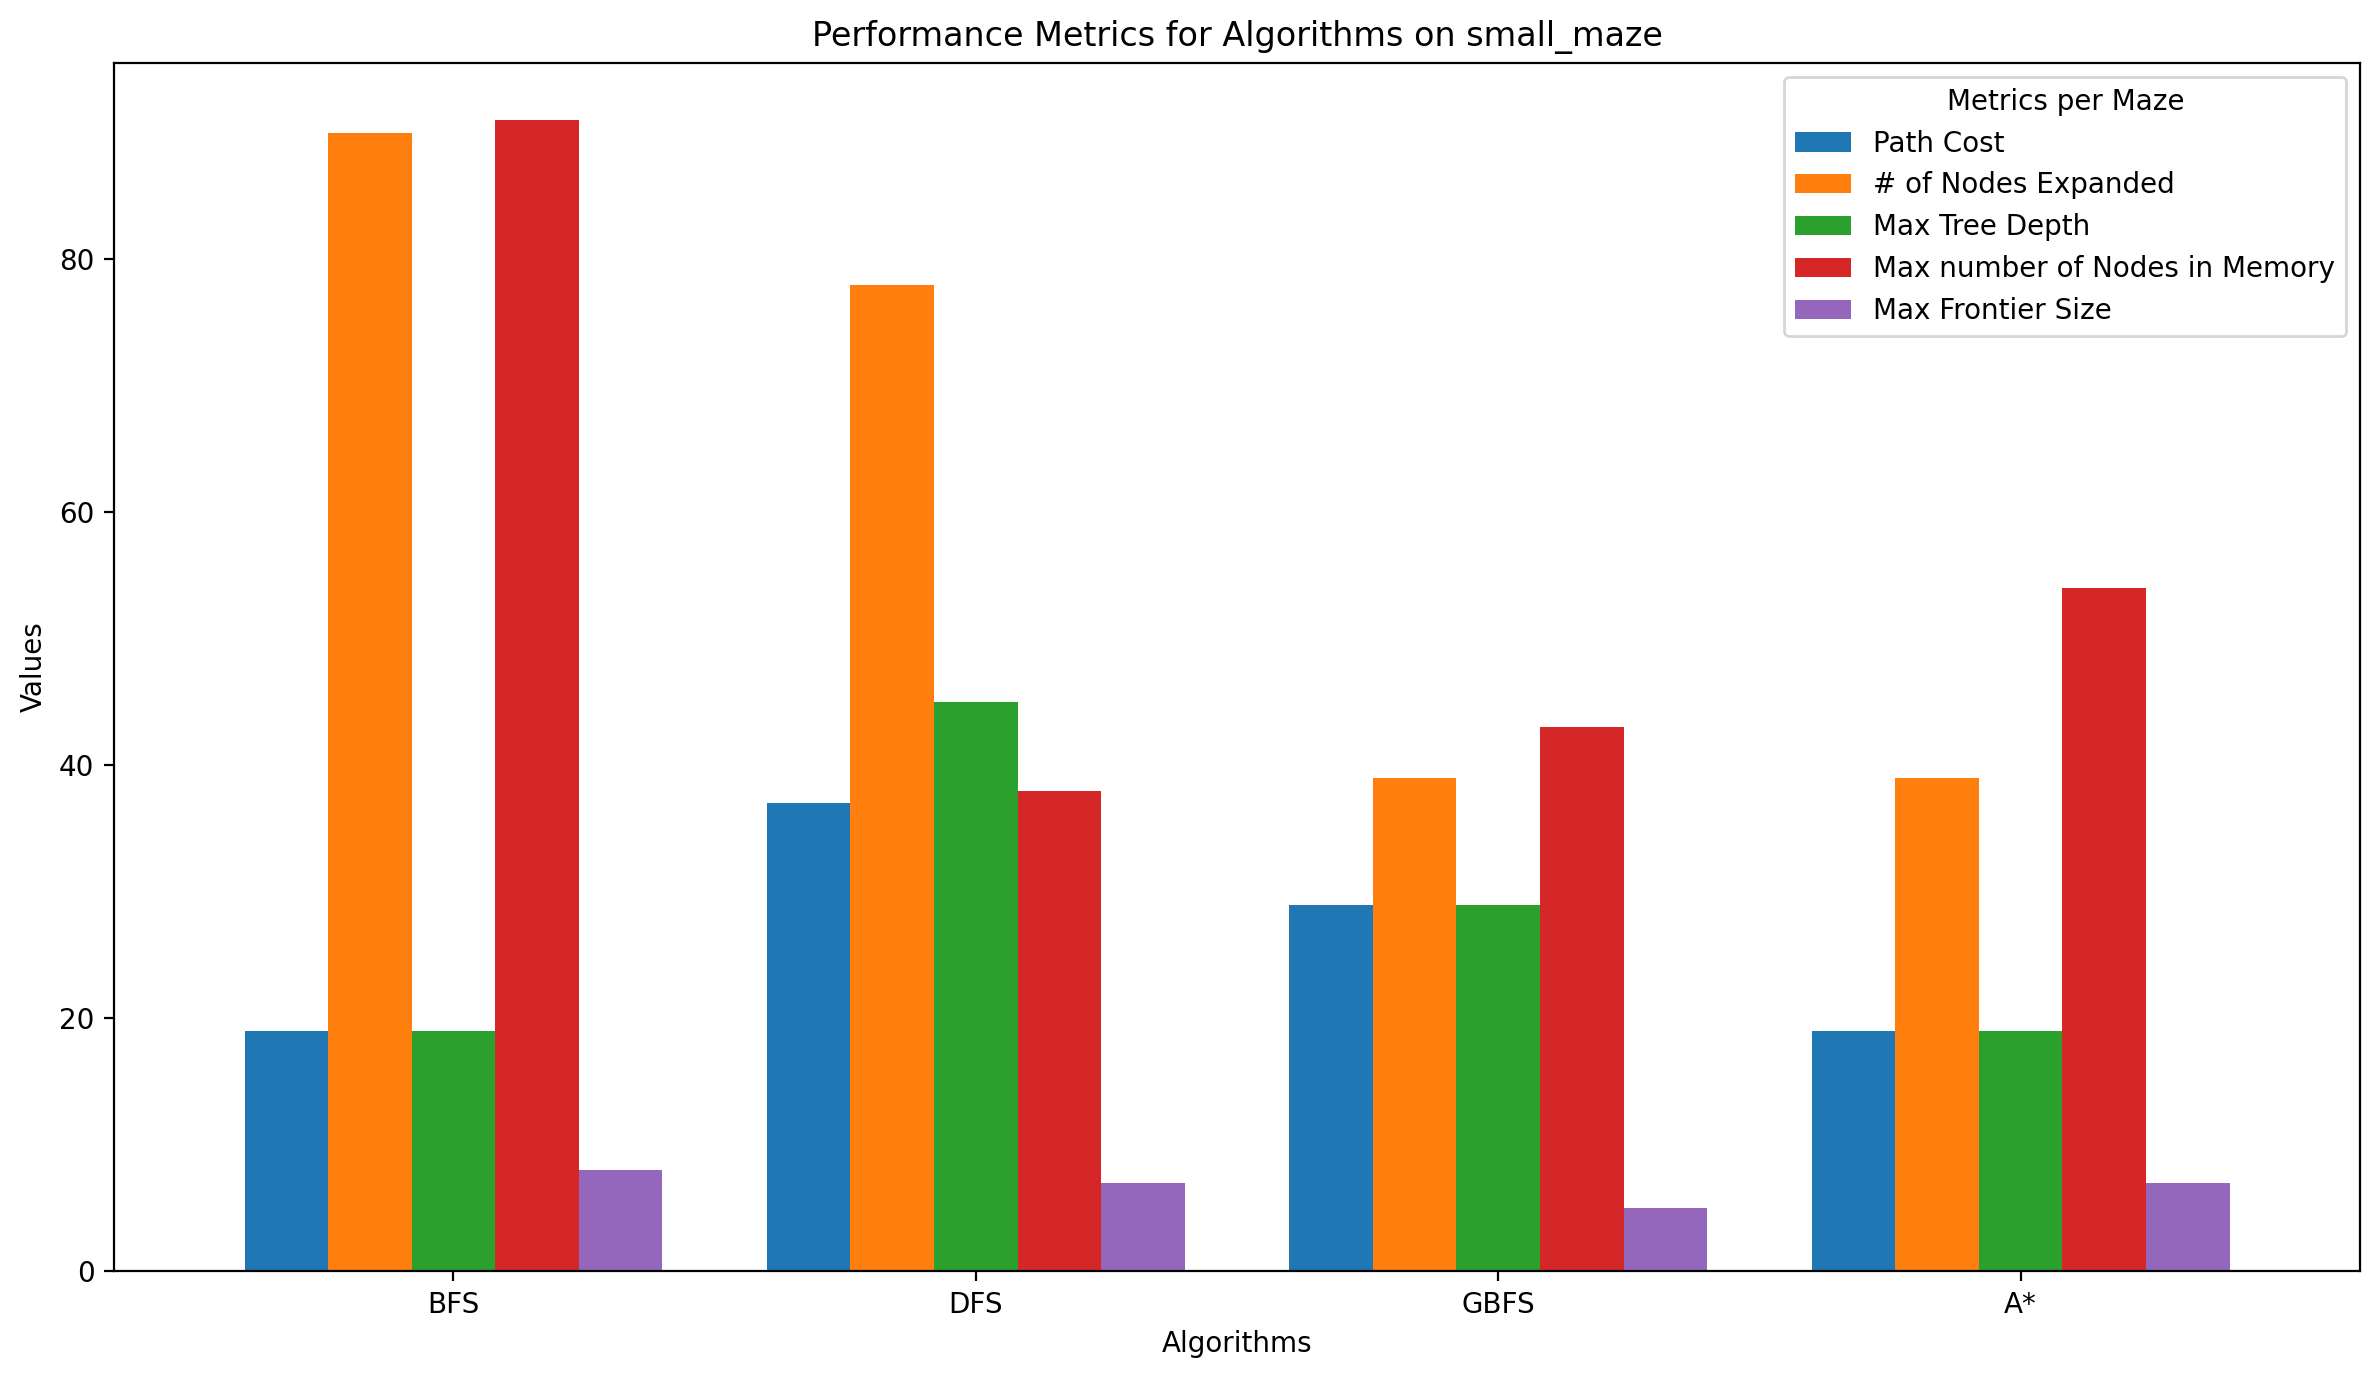

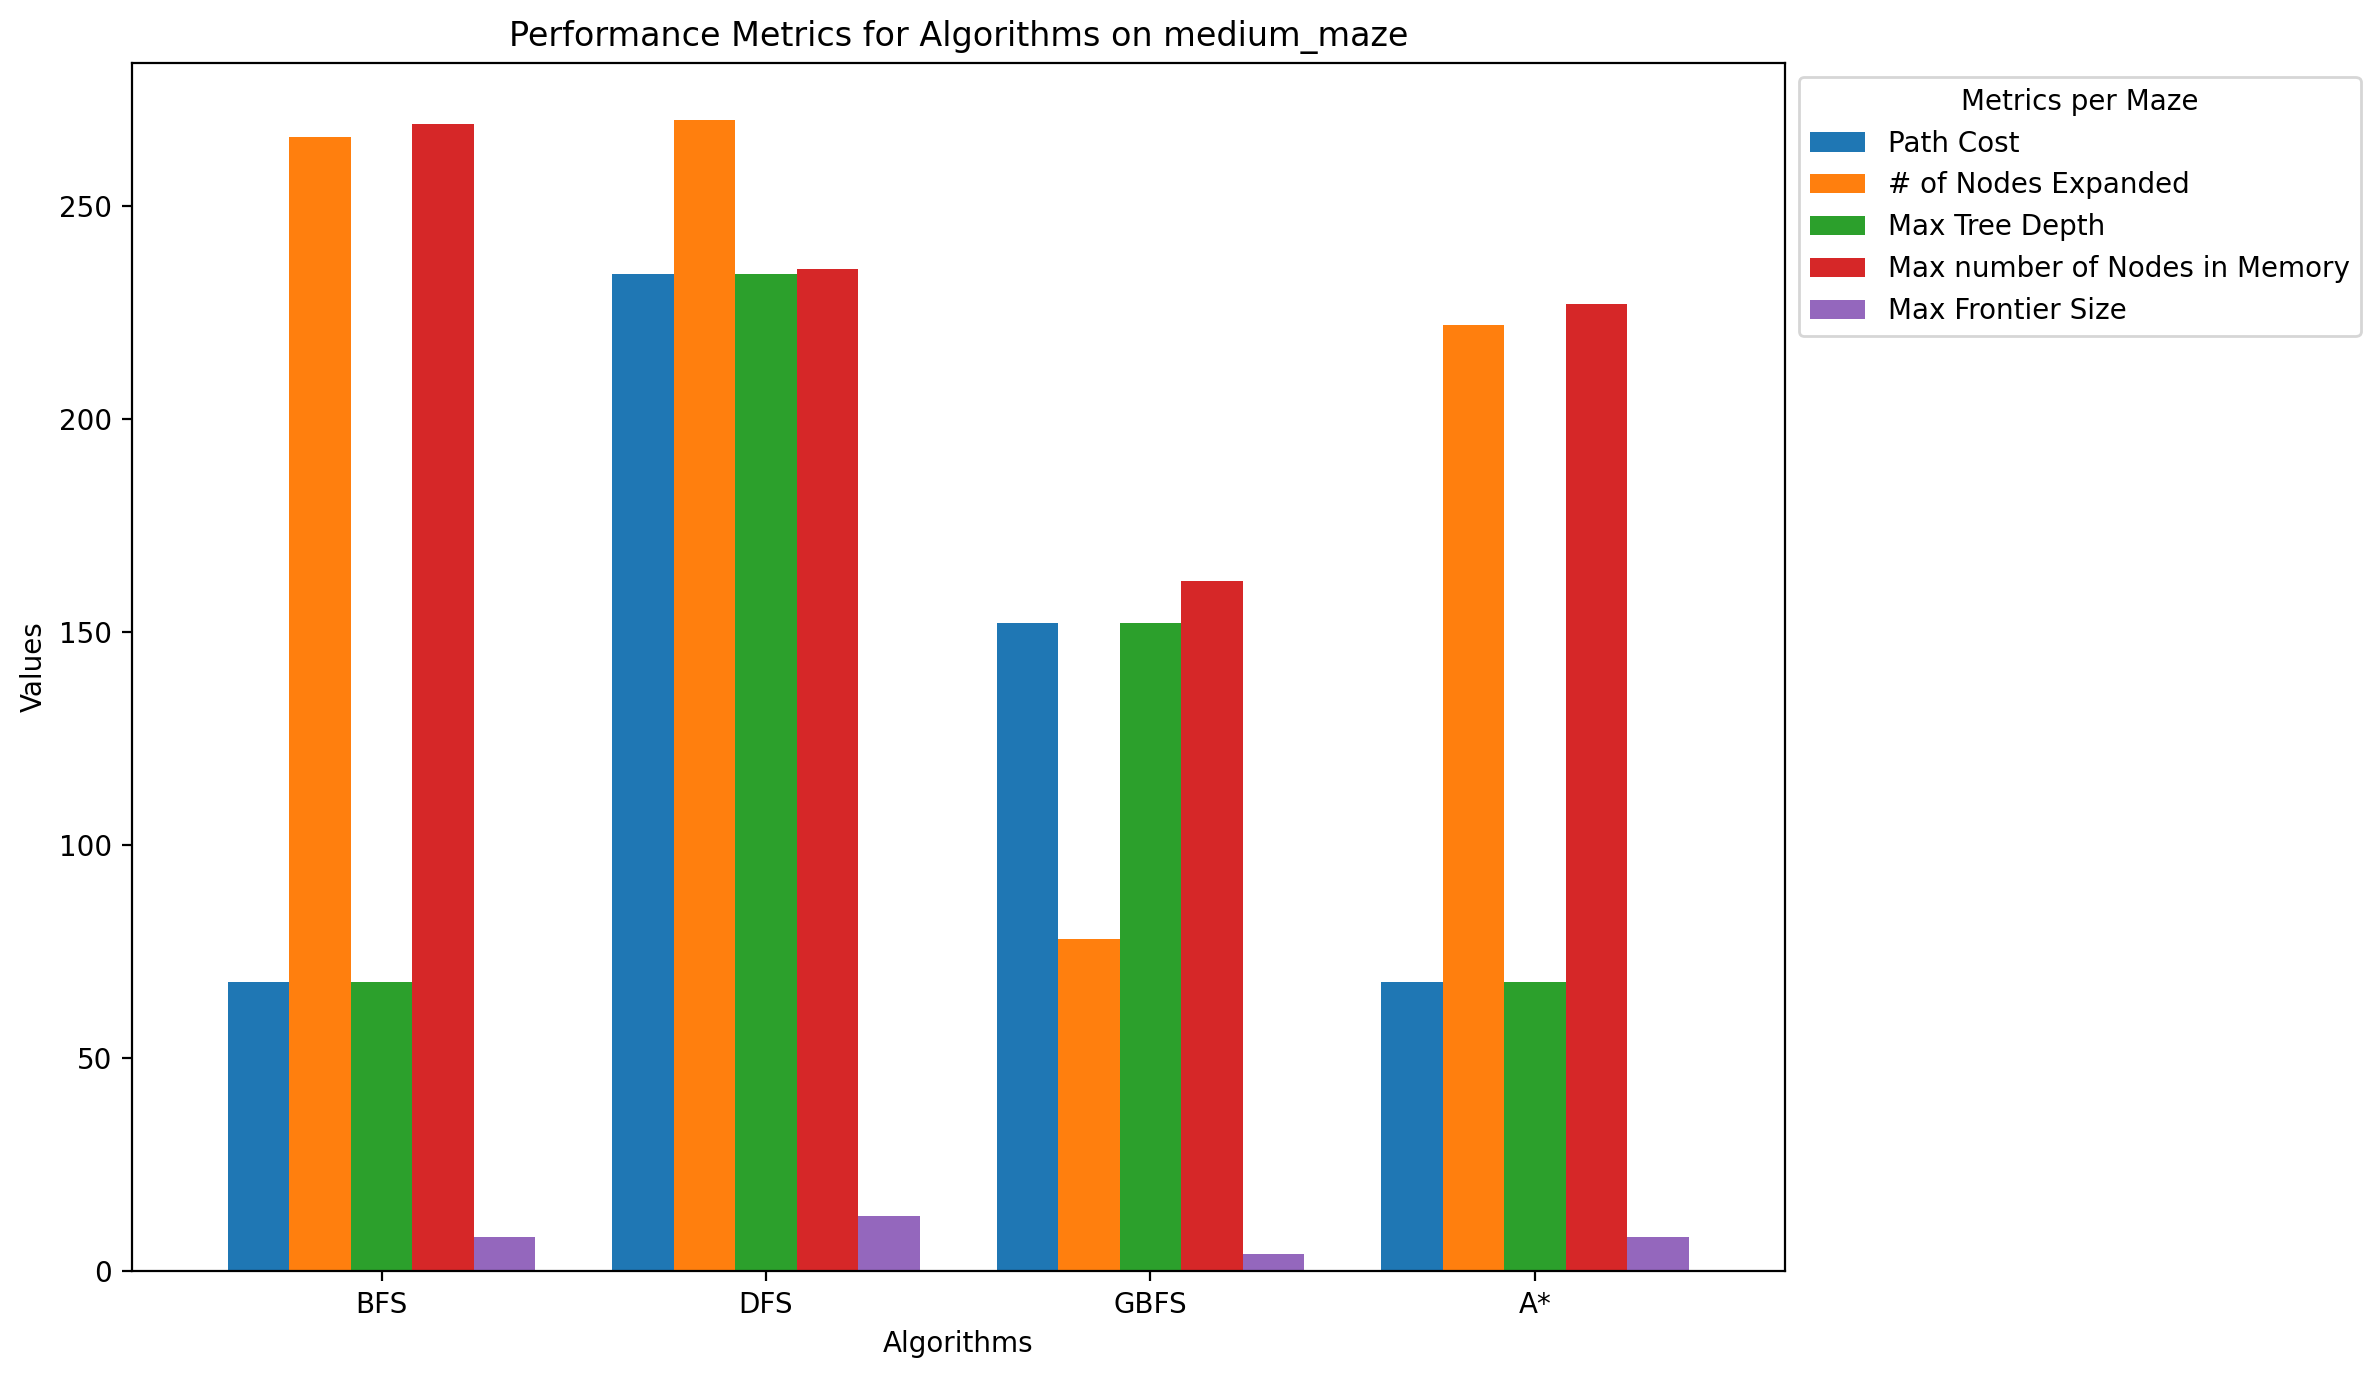

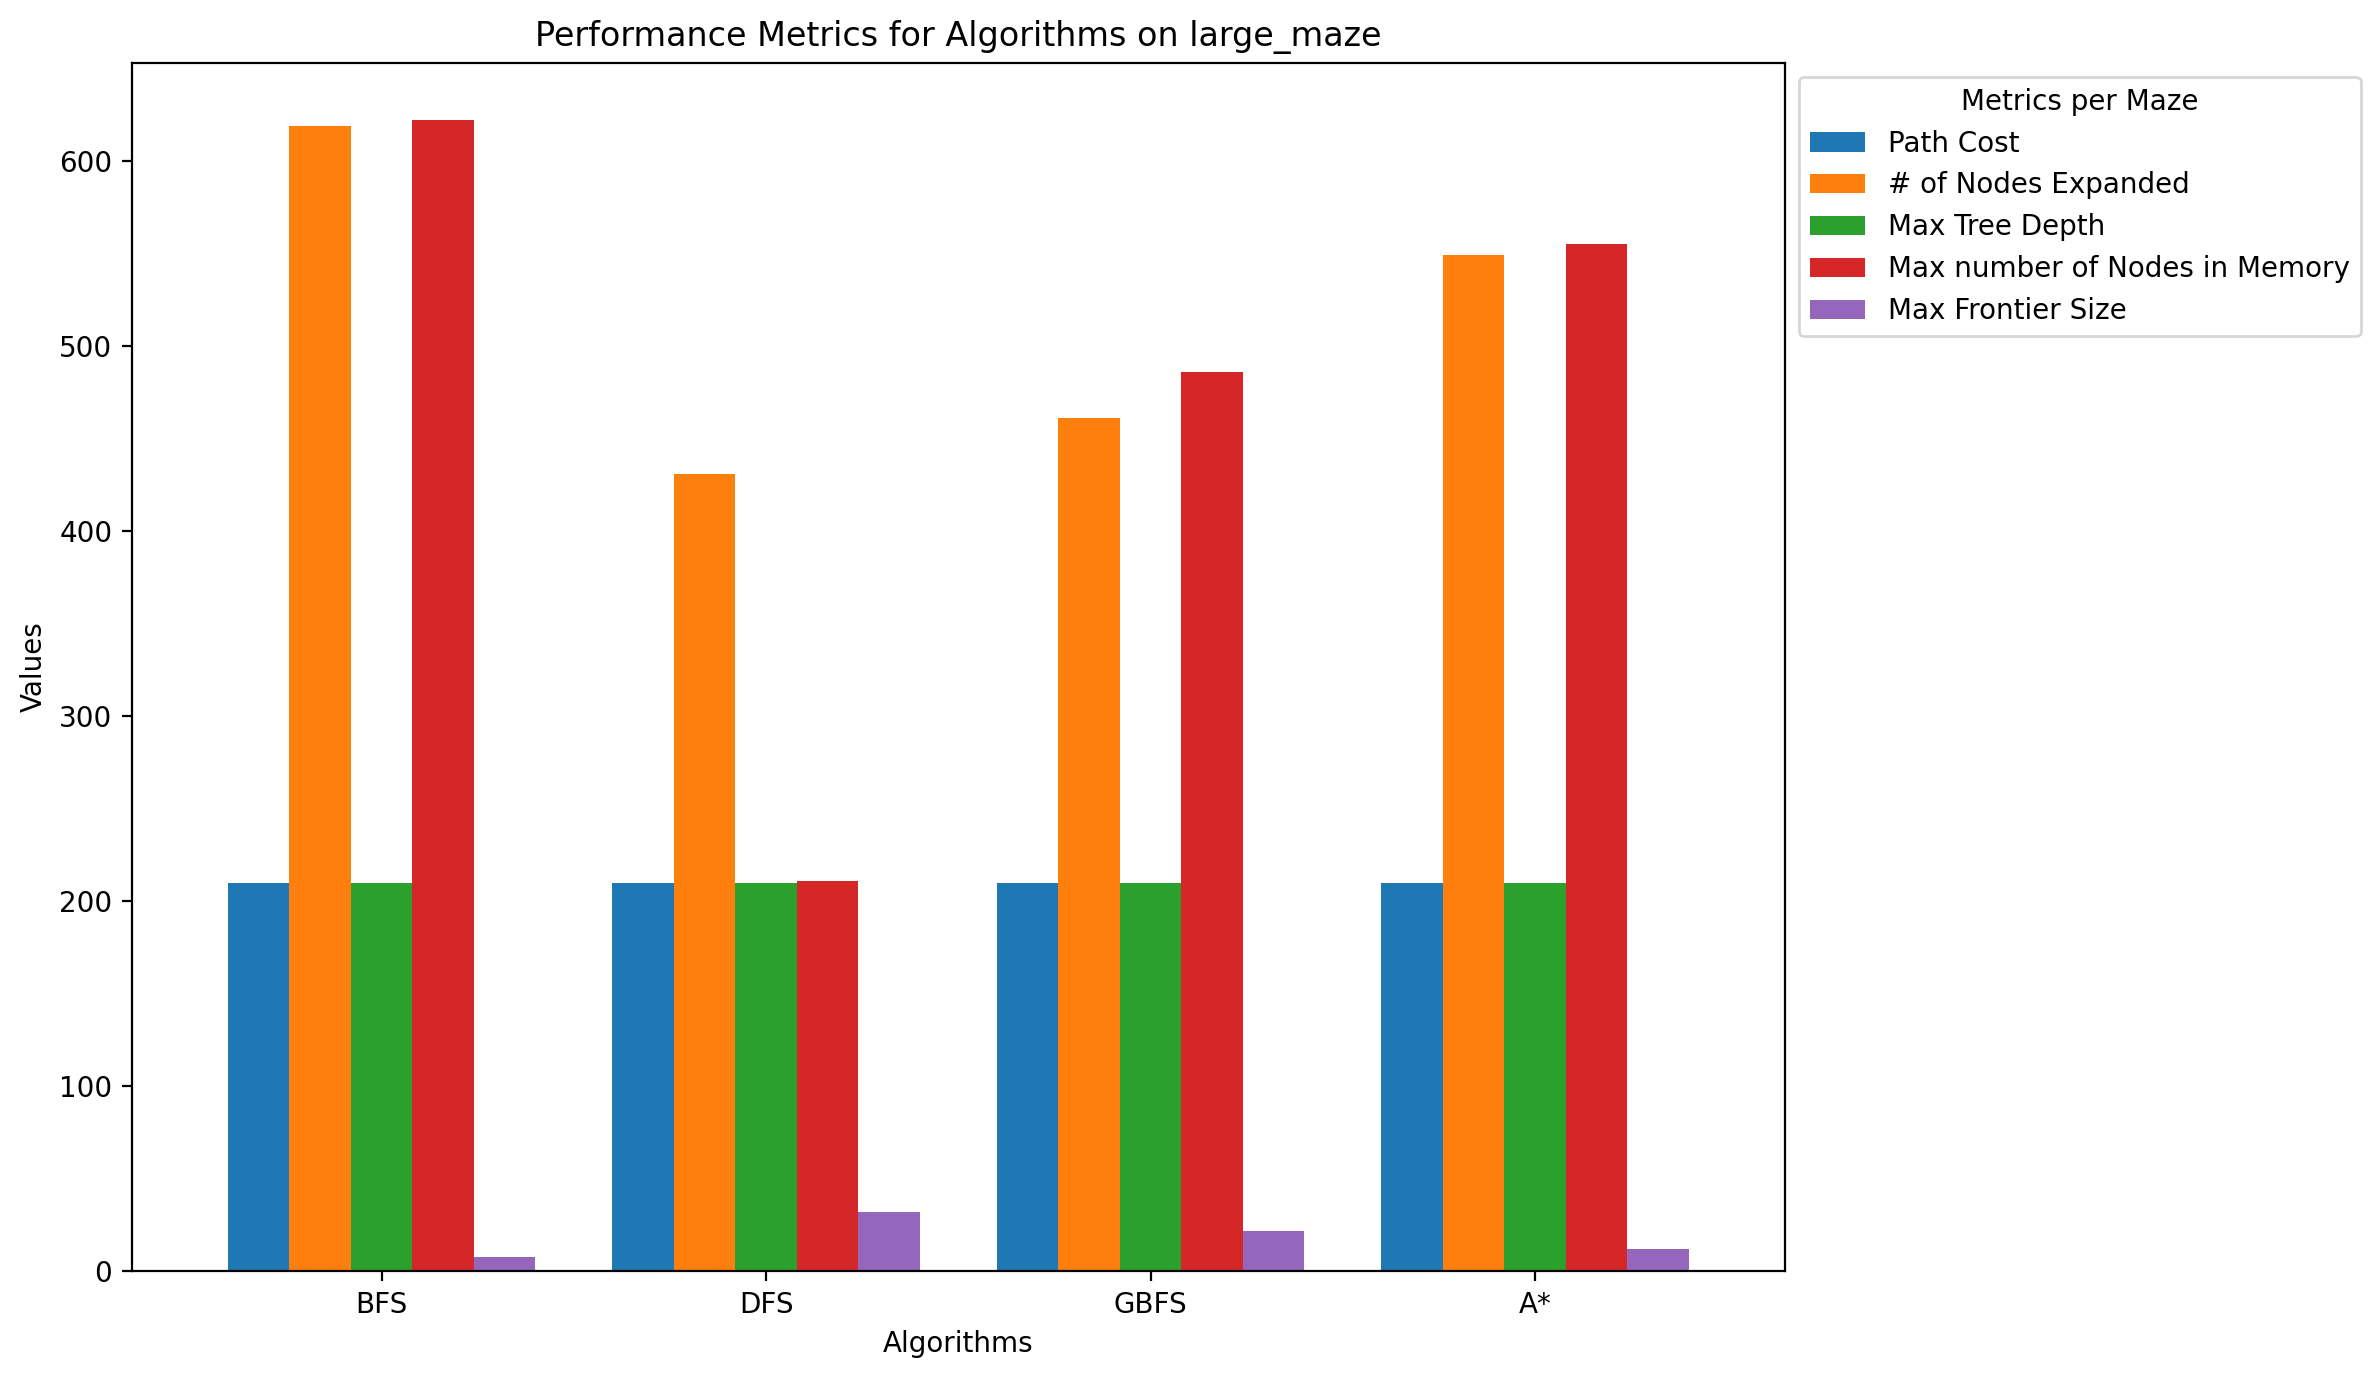

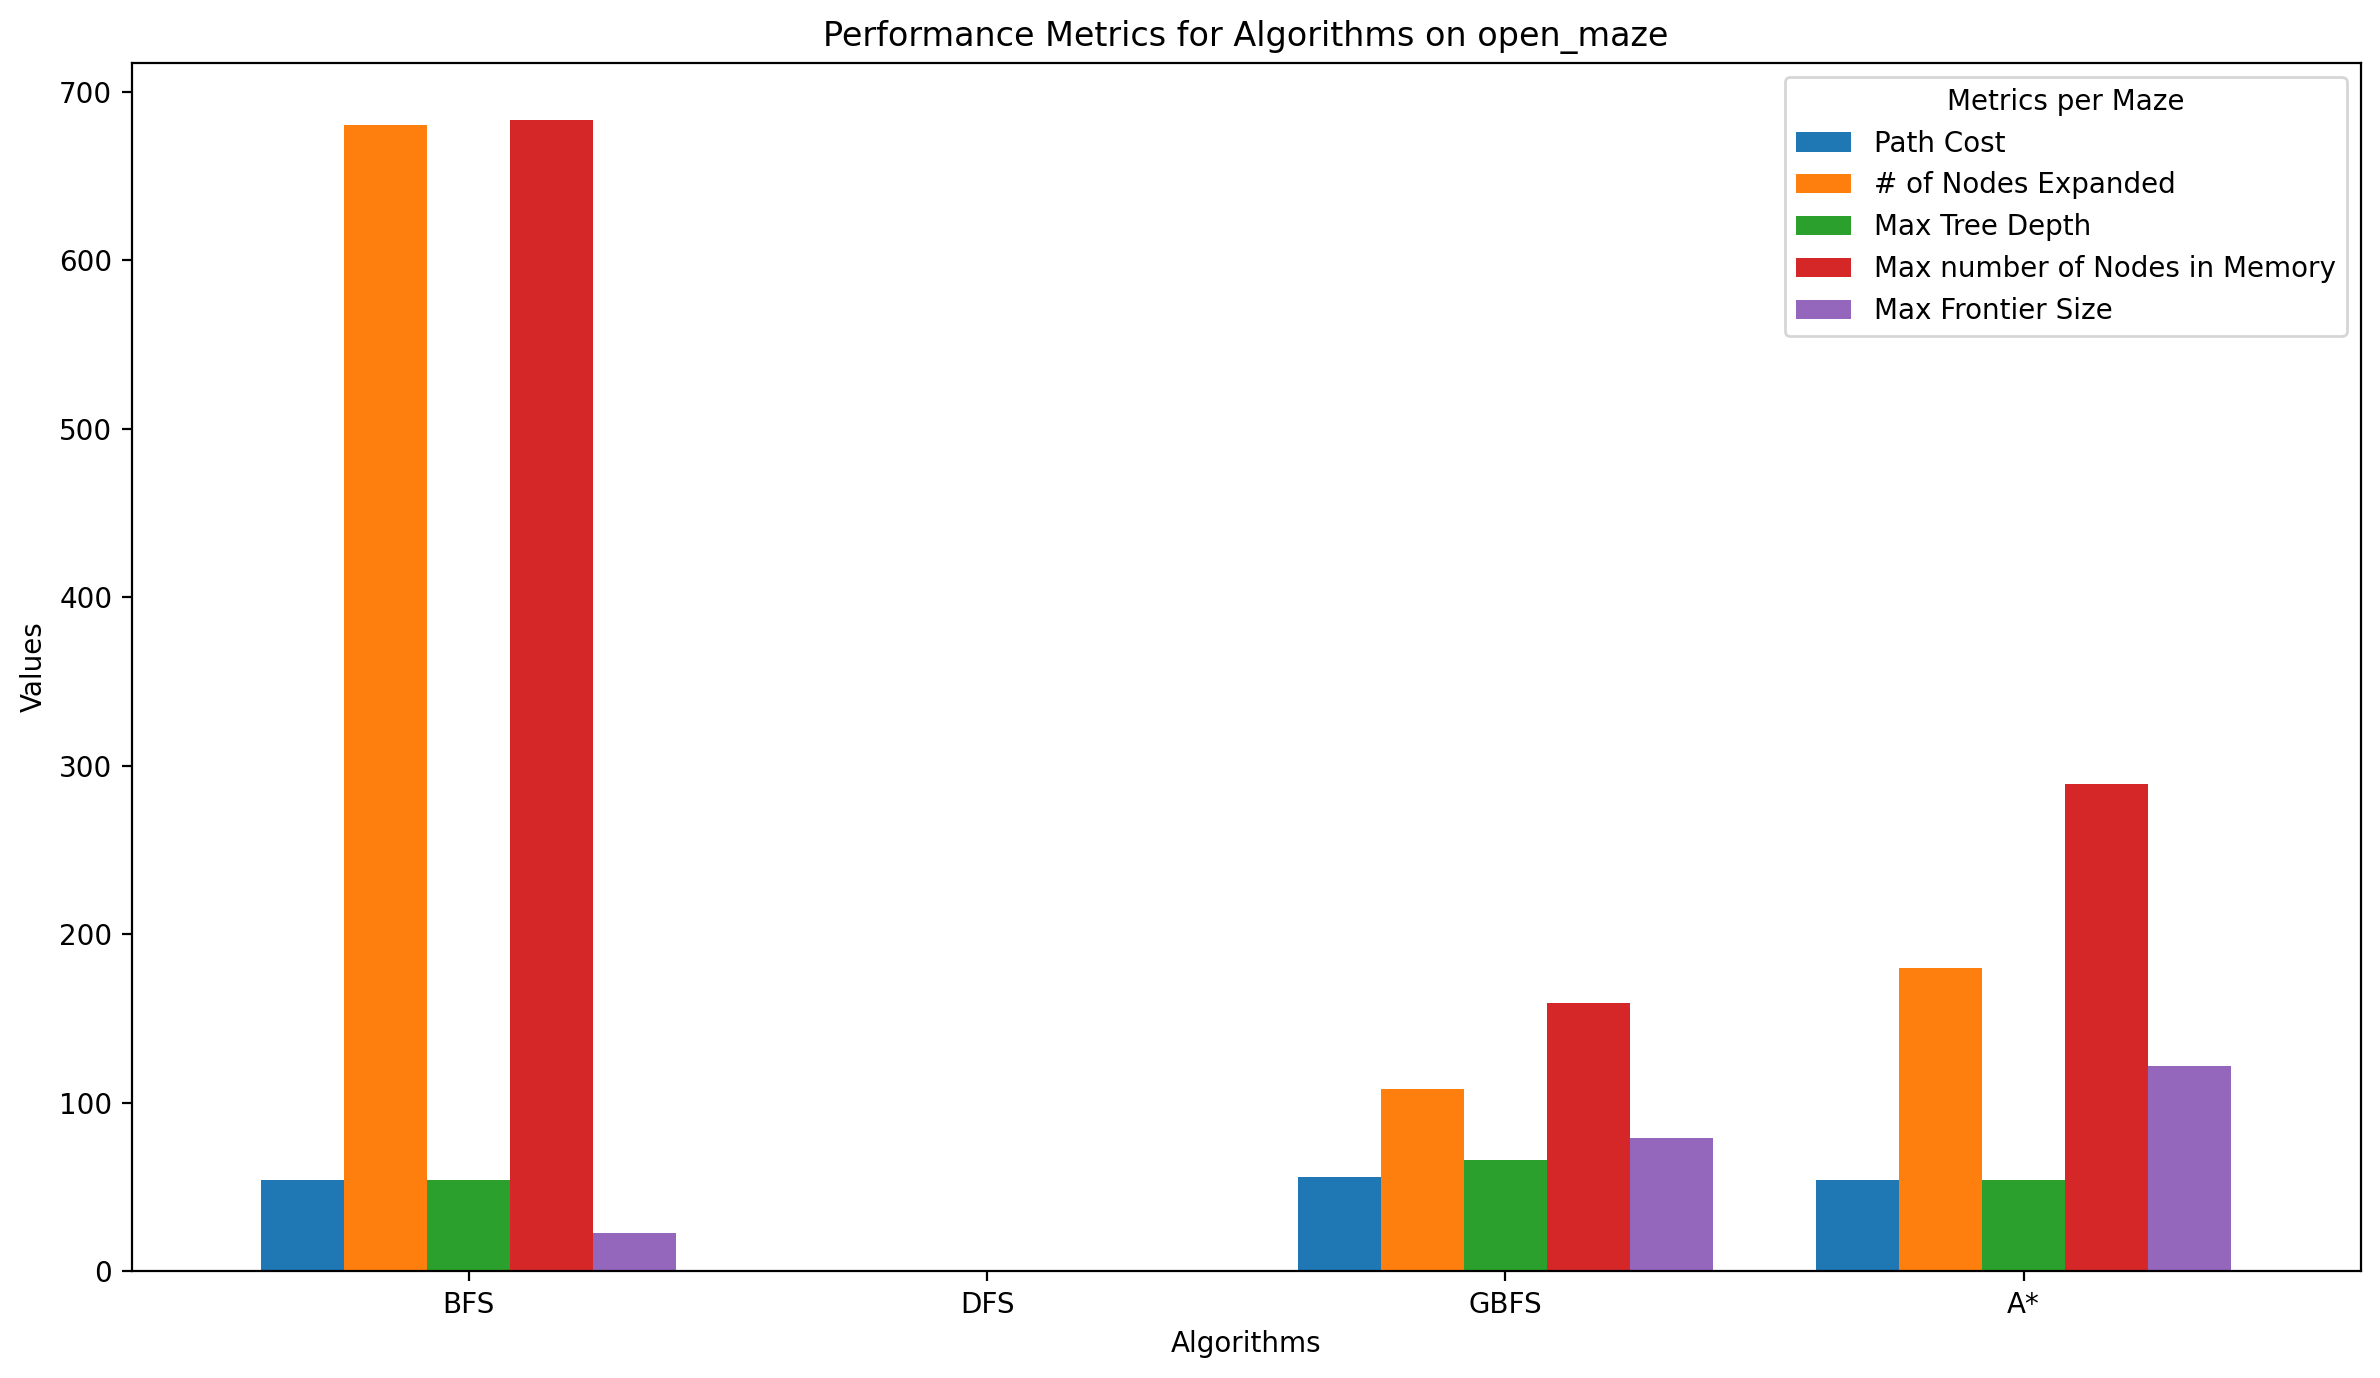

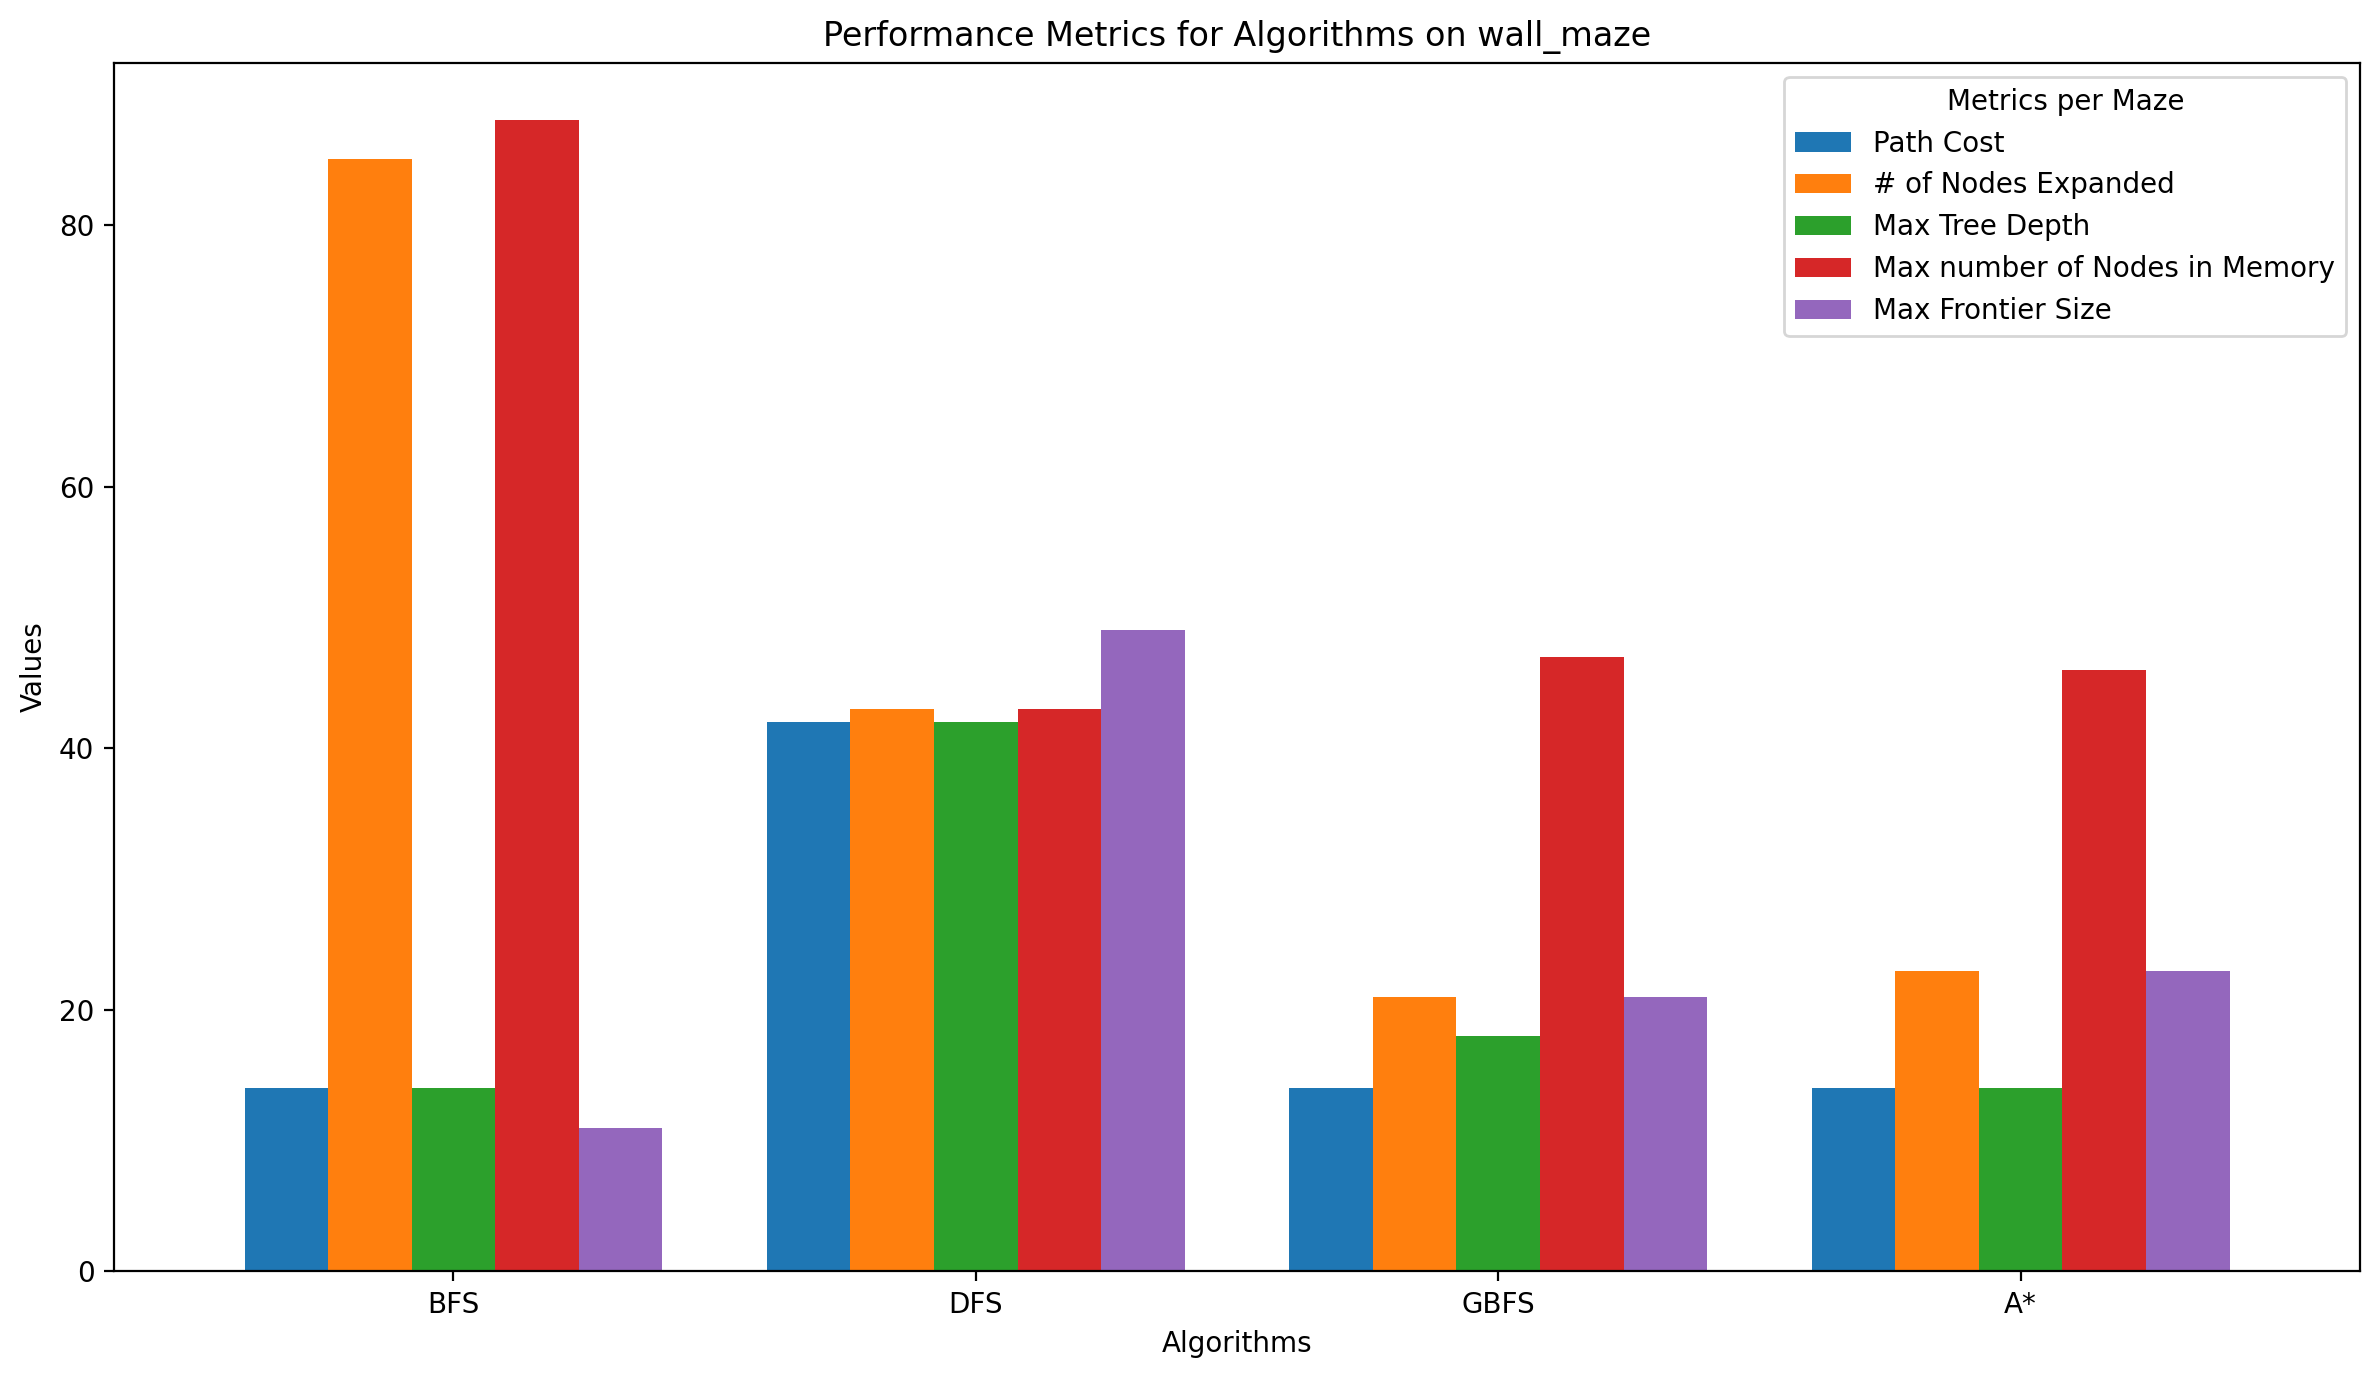

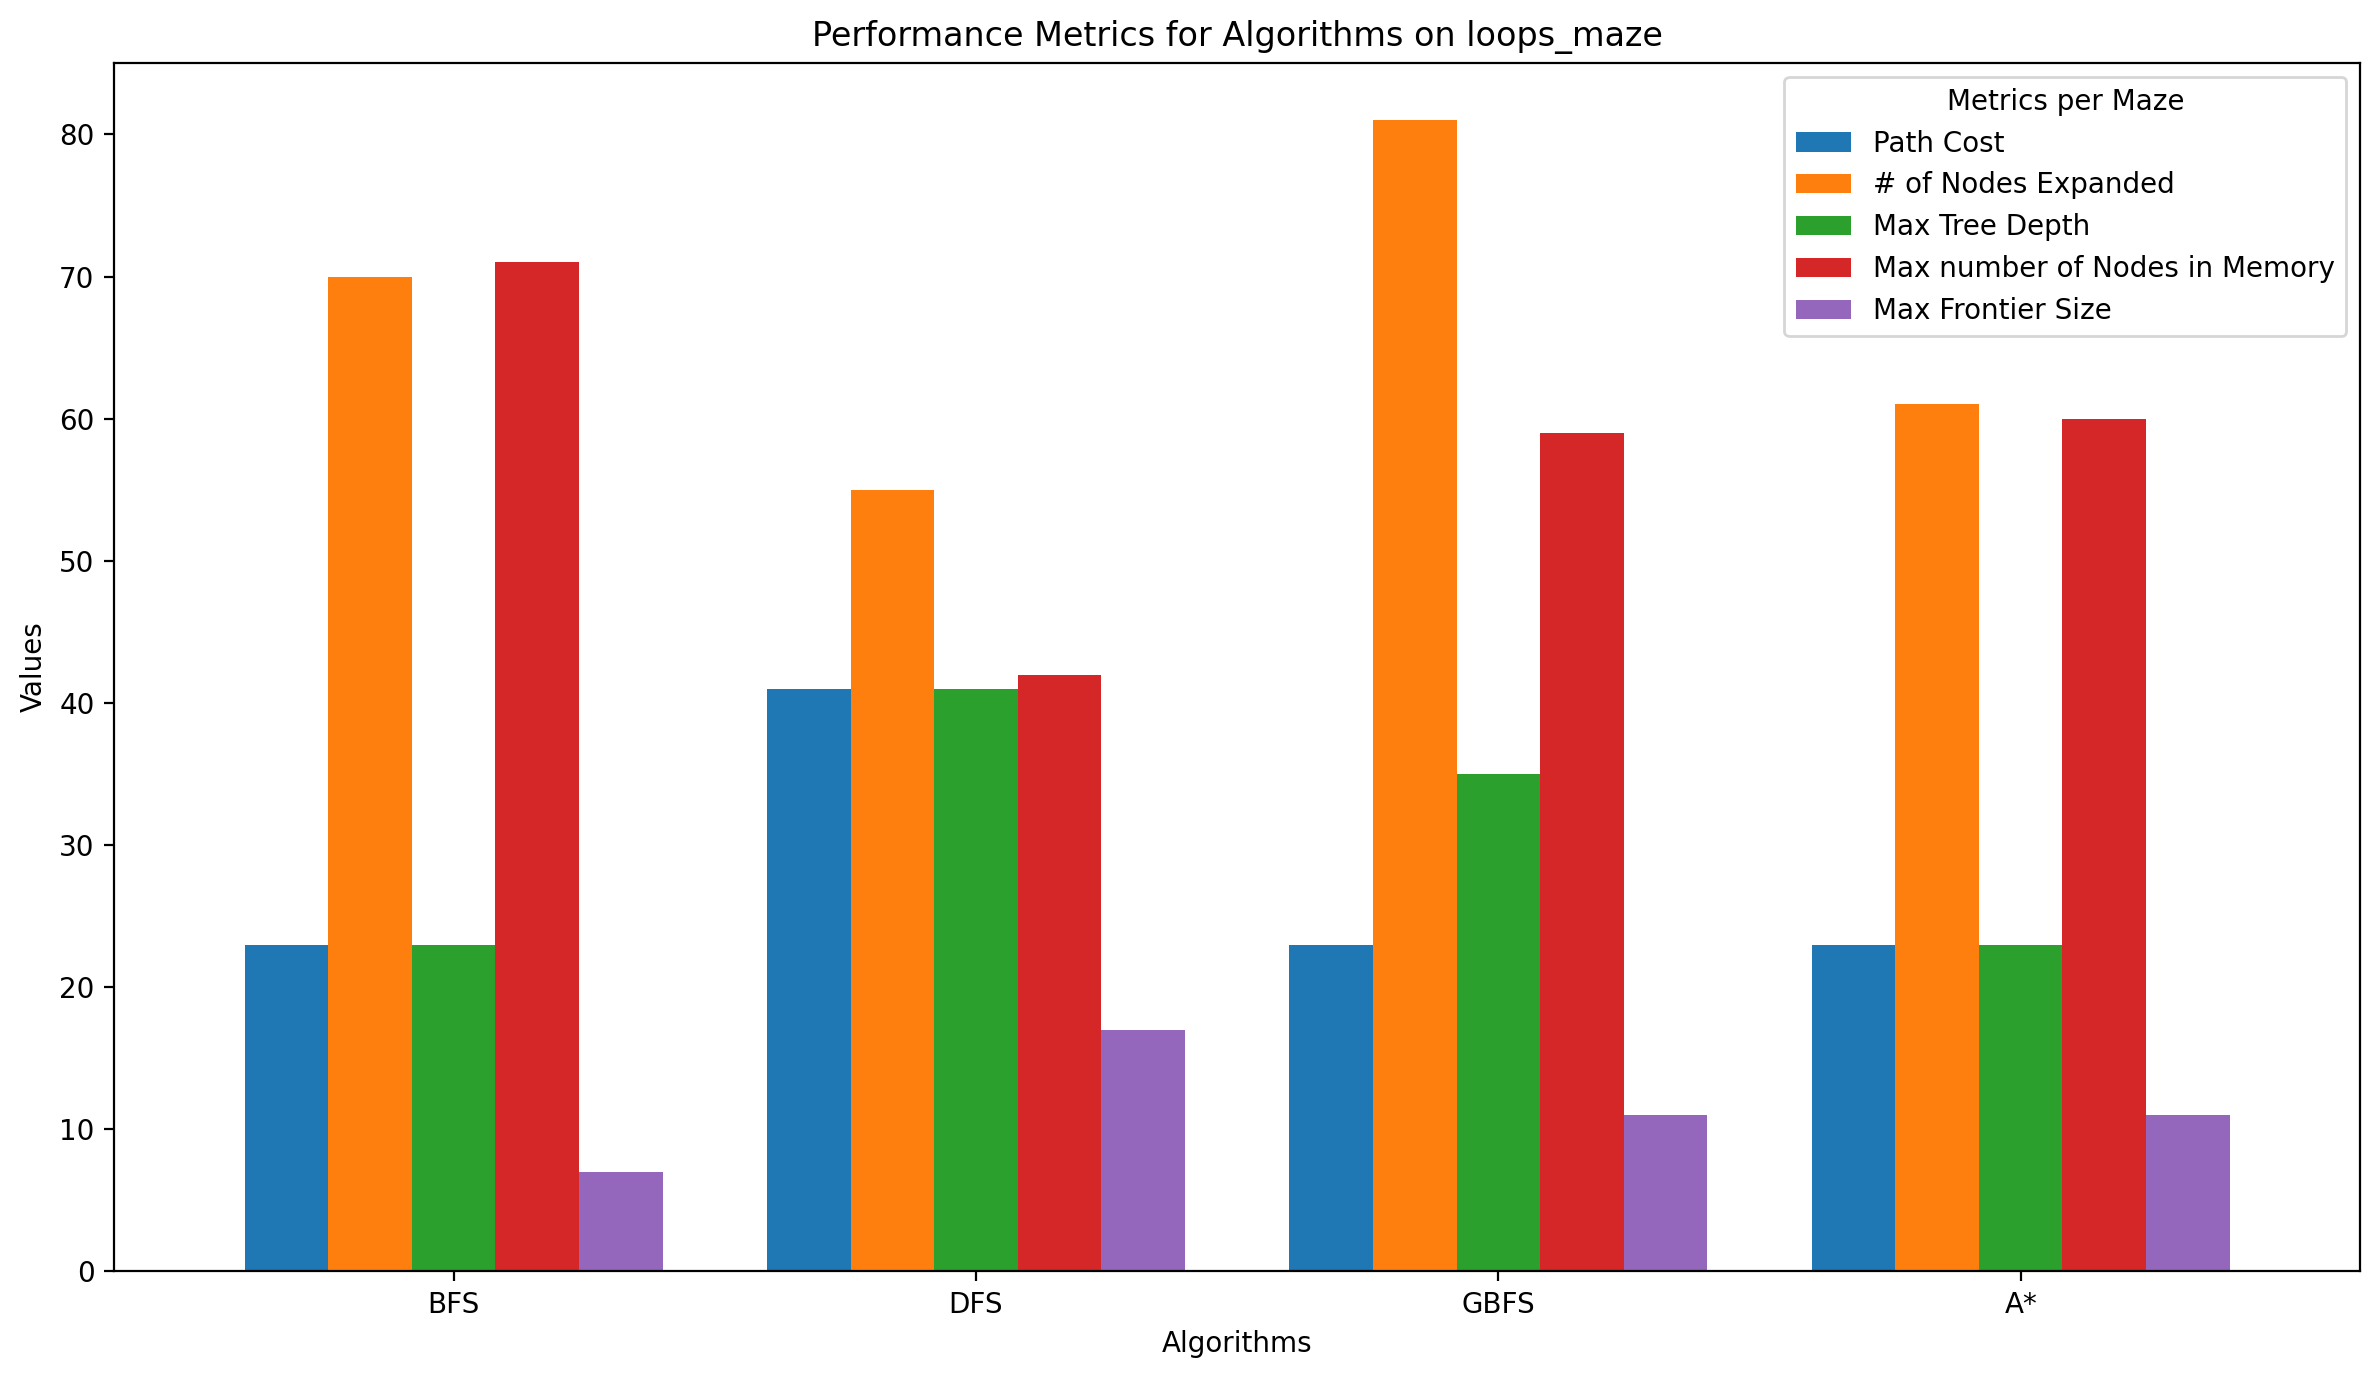

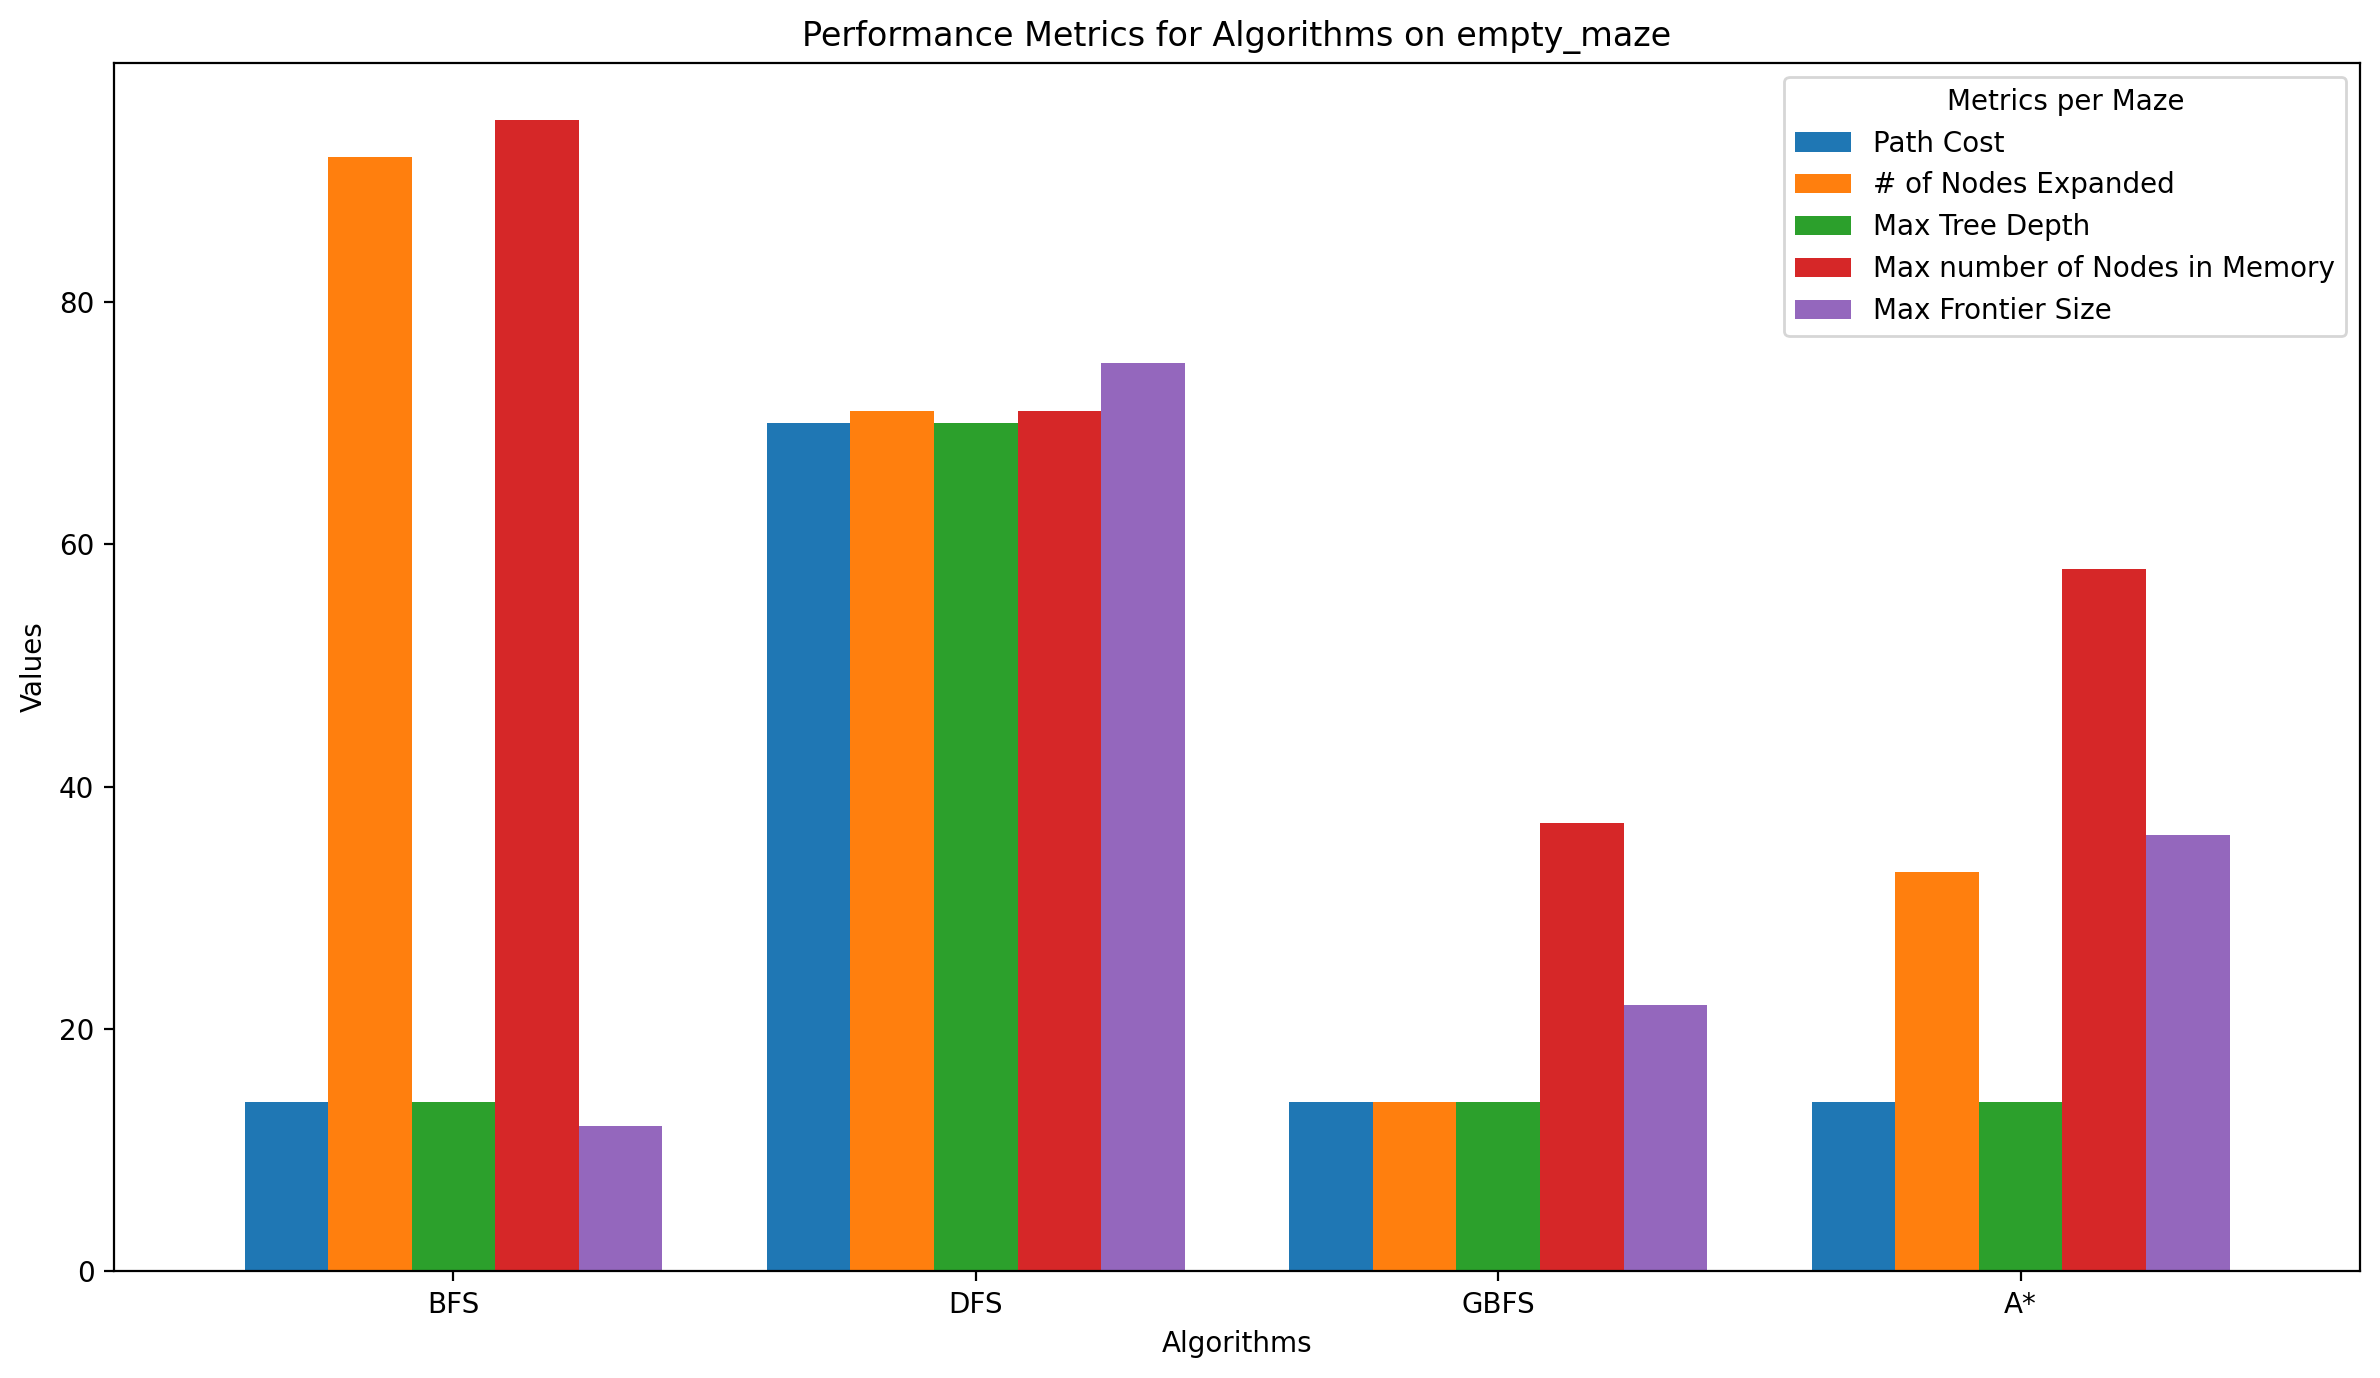

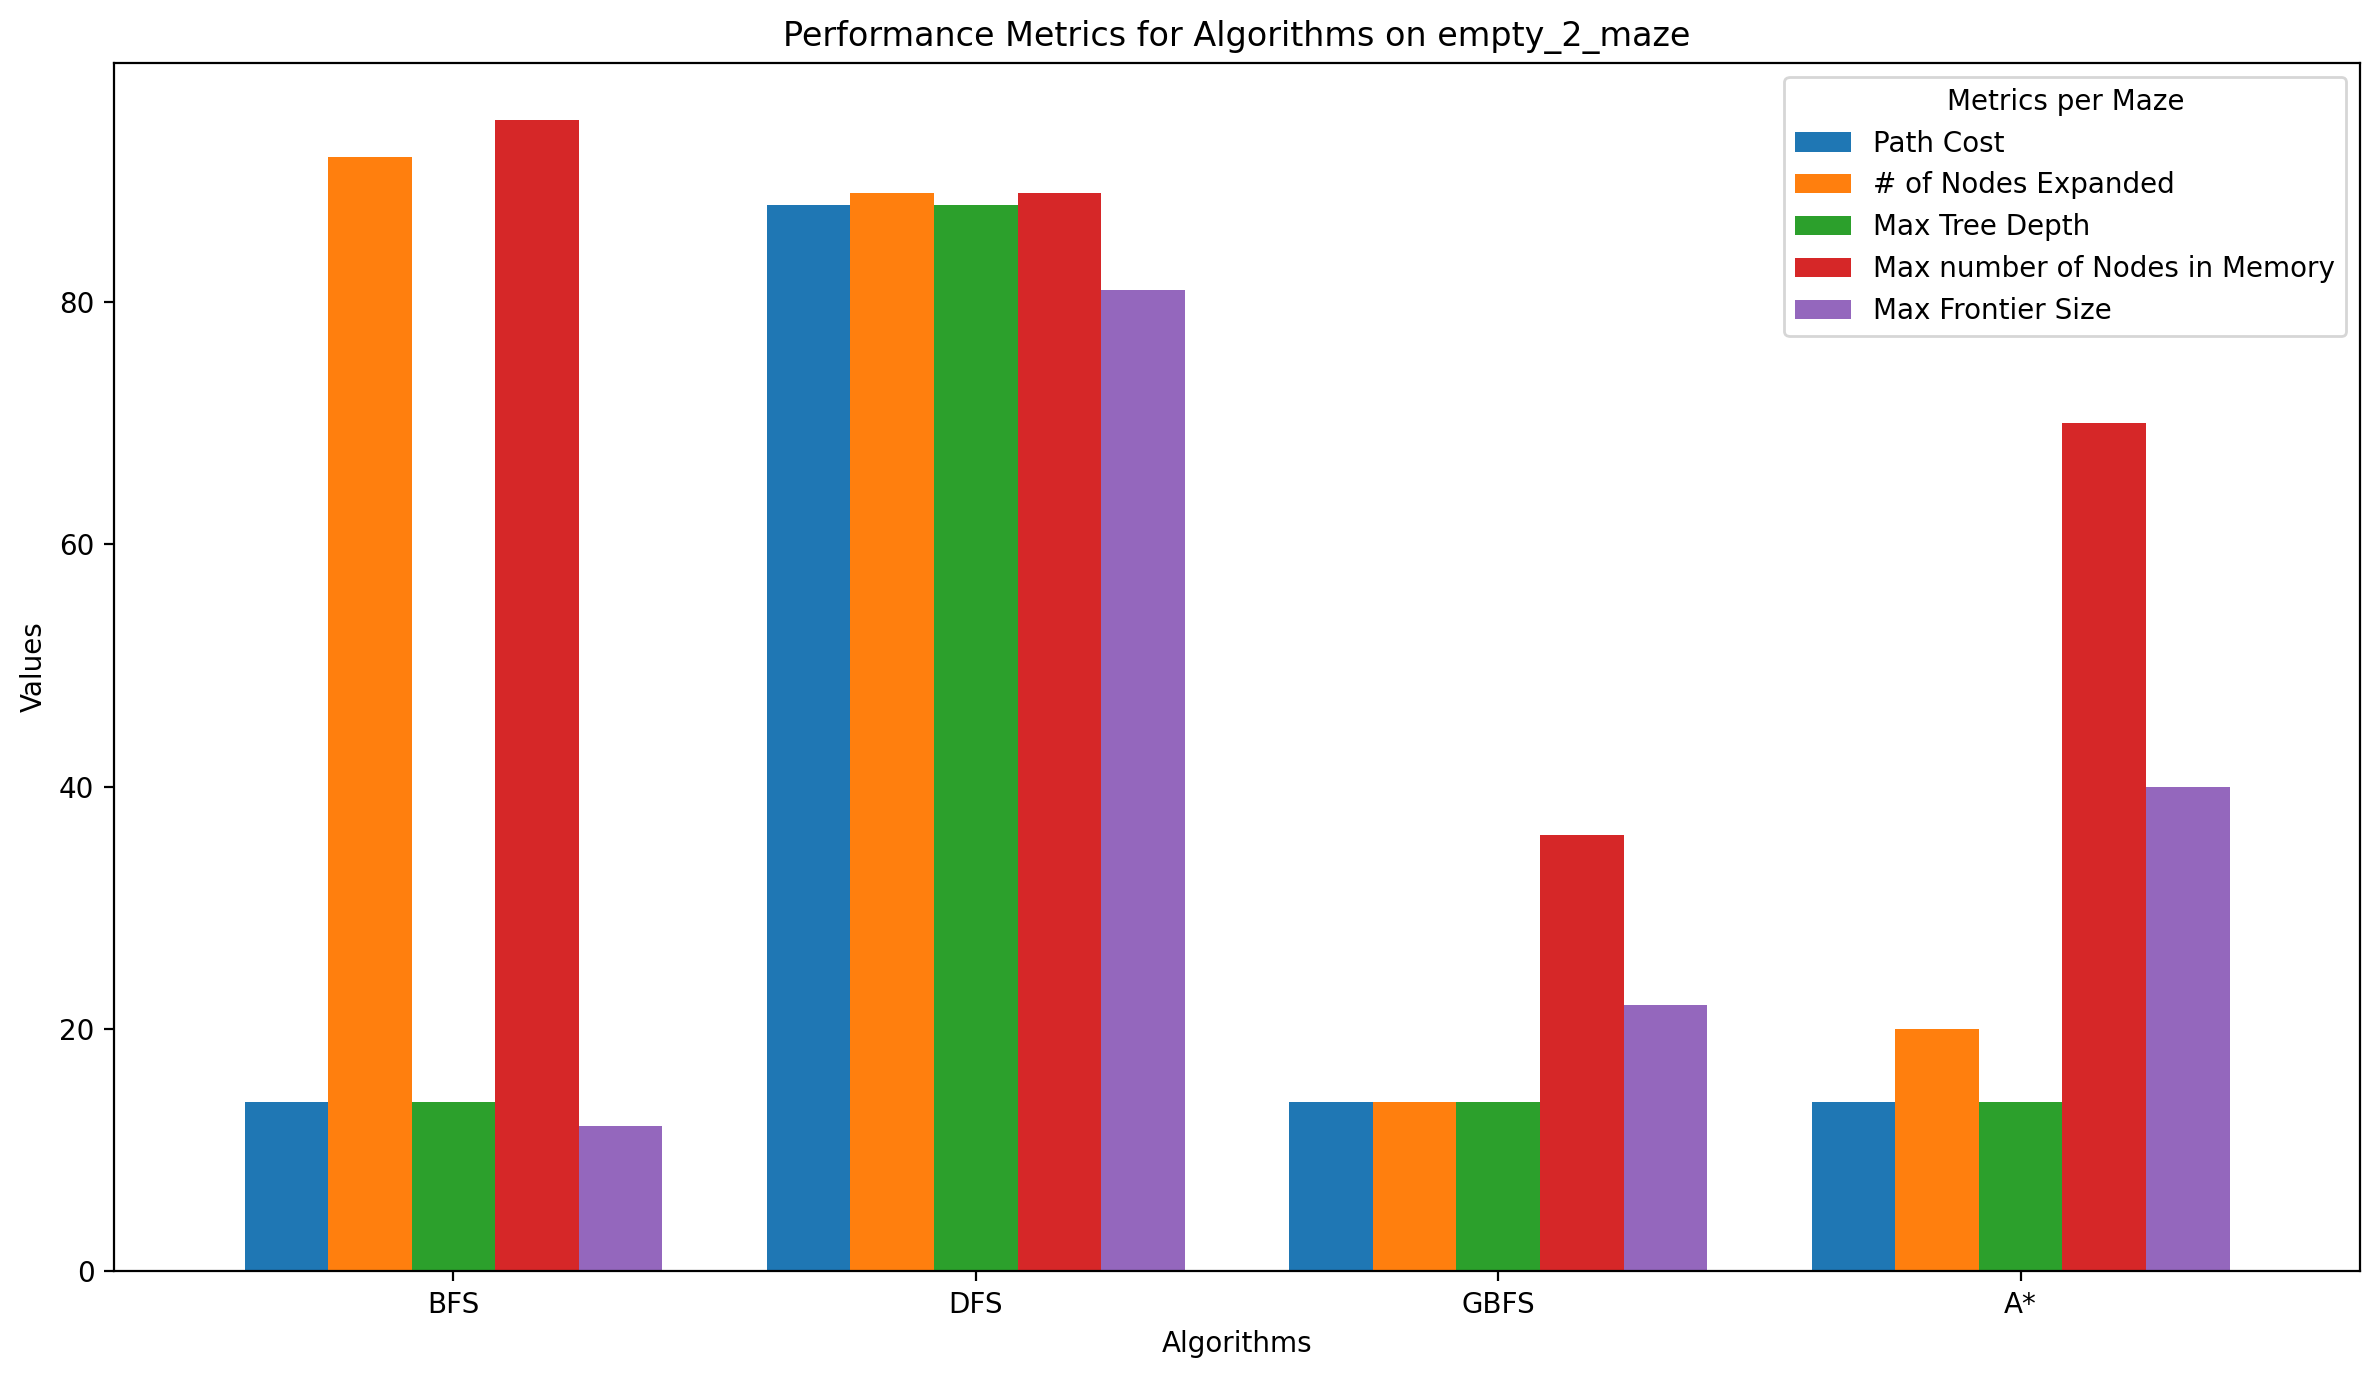

In [14]:
#Based on the routes and their respective data from the tables above the following will now compute
# a bar chart to represent the finding for each maze given each Algorithm
import matplotlib.pyplot as plt
mazes = ["small_maze","medium_maze","large_maze","open_maze","wall_maze","loops_maze","empty_maze","empty_2_maze"]
count = 0
for maze in results:
  df = pd.DataFrame(maze)
  df.replace('N/A*', np.nan, inplace=True)
  x = df["Algorithm"]
  df = df.drop(columns=['Algorithm'])
  ax = df.plot(kind='bar', figsize=(12, 7), width=0.8)
  ax.set_xlabel('Algorithms')
  ax.set_ylabel('Values')
  ax.set_title(f'Performance Metrics for Algorithms on {mazes[count]}')
  ax.legend(title='Metrics per Maze', bbox_to_anchor=(1, 1))
  plt.xticks(range(len(x)), x, rotation=0)
  plt.tight_layout()
  plt.show()
  count += 1

Discuss the most important lessons you have learned from implementing the different search strategies.

Given the following search strategies, the most important lesson I've learned when implementing different search strategies is that going long blind is the most non effective strategy when searching through a maze. Additionally breadth first search is very optimal especially when adding additional parameters to make the path more effective. Also even then, when optimizing sometimes in certain situations searching there's tradeoffs in the optimizations like when comparing the Greedy algorithm with A* algorith in an open maze, number of nodes in memory can be a trade off or even number of nodes expanding. At the end of the day understanding the significance of each of these algorithms in certain situations can help reduce noise and find the most optimal solution.

## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issus, then report and discuss what causes the problems.

In [15]:
# The following code is implemented based on the class lecture
# IDS represents iterative deepening search algorithm

def dls(maze_name,length):
  #print("Start location:", mh.find_pos(maze_name, what = "S"))
  frontier = [(Node(mh.find_pos(maze_name, what = "S"),parent=None, action =None, cost = 0))]
  result = None
  while not frontier == []:
    node = frontier.pop()
    if mh.find_pos(maze_name, what = "G") == node.pos:
      return node
    if depth(node) > length:
      result = node
    elif not is_cycle(node):
      for child in expand(maze_name, node):
        frontier.append(child)
    else:
      continue
  return result

def ids(maze):
  depth = 1000
  while depth:
    result = dls(maze,depth)
    if result != None:
      return result
  return None

def depth(node):
  depth = 0
  while node.parent:
    depth += 1
    node = node.parent
  return depth


def is_cycle(node):
  parent = node.parent
  while parent:
    if parent.pos == node.pos:
      return True
    parent = parent.parent
  return False

In [16]:
#The following will now implement the IDS algorithm with each maze
mazes = ["small_maze","medium_maze","large_maze","open_maze","wall_maze","loops_maze","empty_maze","empty_2_maze"]
for i in mazes:
  if i == "open_maze":
    continue
  with open(f"/content/drive/My Drive/Colab Notebooks/{i}.txt", "r") as f:
    maze_str = f.read()
  maze = mh.parse_maze(maze_str)
  print(maze_str)
  print(ids(maze))

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX

Node - pos = (8, 1); action = West; cost = 37.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
X                                 SX
X XXXXXXXXXXXXXXXXXXXXXXX XXXXXXXX X
X XX   X   X      XXXXXXX   XX     X
X XX X X X X XXXX XXXXXXXXX XX XXXXX
X XX X X X X             XX XX     X
X XX X X X X X XXXX  XXX    XXXXXX X
X X  X X X   X    XX XXXXXXXX      X
X XX X X XXXXXXXX XX        XX XXXXX
X XX X   XX       XXXXXXXXX XX     X
X    XXXXXX XXXXXXX      XX XXXXXX X
XXXXXX      X       XXXX XX X      X
X      XXXXXX XXXXX X    XX XX XXXXX
X XXXXXX      X       XXXXX XX     X
X        XXXXXX XXXXXXXXXXX XX  XX X
XXXXXXXXXX                  XXXXXX X
XG         XXXXXXXXXXXXXXXX        X
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


Node - pos = (16, 1); action = West; cost = 234.0
XXX

### Multiple Goals
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [17]:
mazes = ["medium_maze","medium_maze_goals2","medium_maze_goals3"]
for i in mazes:
  if i == "open_maze":
    continue
  with open(f"/content/drive/My Drive/Colab Notebooks/{i}.txt", "r") as f:
    maze_str = f.read()
  maze = mh.parse_maze(maze_str)
  print(f"The following maze was evaluated: {i} against BFS algorithm\n{bfs(maze)}\n")
  print(f"The following maze was evaluated: {i} against DFS algorithm\n{DFS(maze)}\n")
  print(f"The following maze was evaluated: {i} against ids algorithm\n{ids(maze)}\n")


The following maze was evaluated: medium_maze against BFS algorithm
Node - pos = (16, 1); action = West; cost = 68.0

The following maze was evaluated: medium_maze against DFS algorithm
Node - pos = (16, 1); action = West; cost = 234.0

The following maze was evaluated: medium_maze against ids algorithm
Node - pos = (16, 1); action = West; cost = 234.0

The following maze was evaluated: medium_maze_goals2 against BFS algorithm
Node - pos = (10, 1); action = South; cost = 42.0

The following maze was evaluated: medium_maze_goals2 against DFS algorithm
Node - pos = (10, 1); action = South; cost = 114.0

The following maze was evaluated: medium_maze_goals2 against ids algorithm
Node - pos = (10, 1); action = South; cost = 114.0

The following maze was evaluated: medium_maze_goals3 against BFS algorithm
Node - pos = (10, 1); action = South; cost = 42.0

The following maze was evaluated: medium_maze_goals3 against DFS algorithm
Node - pos = (10, 1); action = South; cost = 114.0

The followi

Based on the following results it looks like although implementing IDS the same path cost can end up being like DFS. Which is not optimal leaving BFS still the most effective in this case.